# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go

import datetime
from time import time
%matplotlib inline
import re

#import pyspark libraries
import pyspark
from pyspark import SparkConf

# import sql Spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, regexp_replace, concat, count, desc, asc, explode, lit, split, stddev, udf, lower, isnan, when, rank, from_unixtime

# import ml Spark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("My Sparkify app") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'My Sparkify app'),
 ('spark.app.id', 'local-1615742784990'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '914a6dbfa26b'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '32885')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# import mini-dataset file
file = "./mini_sparkify_event_data.json"
df = spark.read.json(file)

In [6]:
# Let's check the dataset
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
# Let's calculate the number of rows the file has --> 286.500 rows
df.count()

286500

Now, let's prepare some functions that we will use later

In [8]:
# Let's build a function to count the nulls/missing/empty values
def count_null_col(df,column):
    '''
    Function that counts the nulls or missing values that exist in a column
    Input:  
            df: dataset where we want to count null/missing/empty values
            column: column of the dataset we want to count null/missing/empty values
    Output: 
            n_missing: it returns the number of missing values
    '''
    missing = df.filter(((df[column].isNull()) | isnan(df[column])) | (df[column] == ""))
    n_missing = missing.count()
    
    return n_missing

In [9]:
# Let's build a function to count the nulls/missing/empty values of every column of the dataset
def count_null_df(df):
    '''
    Function that counts the nulls or missing values that exist in a dataset
    Input:  
            df: dataset where we want to count null/missing/empty values
    Output: 
            missing: it returns a dictionary with the number of missing values of every column
            in case the column has nulls/missing/empty values
    '''   
    missing = {}
    for col in df.columns:
        n_missing = count_null_col(df,col)
        if n_missing > 0:
            missing.update({col: n_missing})
    
    return missing      

In [10]:
# Let's build a function to count if the categorical and numerical columns of the dataset
def cat_or_num(df):
    '''
    Function that clasifies the kind of columns (categorical or numerical) that exist in a dataset
    Input:  
            df: dataset where we want to clasify columns
    Output: 
            num_cols,cat:cols: it returns a dictionary with the category of every column
    
    '''   
    cat_cols = []
    num_cols = []

    for coltype in df.schema:
        ctype = str(coltype.dataType)
        if ctype == "StringType":
            cat_cols.append(coltype.name)

        elif ctype == "LongType" or ctype == "DoubleType":
            num_cols.append(coltype.name)
            
    return cat_cols, num_cols

In [11]:
# get information about the cols and features
def show_cols_info(df):
    '''
    Function that shows the summary of the information of the columns of the datasets
    Input:  
            df: dataset we want to show information 
    Output: 
            none: it prints a summary and the main values of every column
    
    '''     

    for column in df.columns:
        # show a summary of the important information of the column
        df.describe([column]).show()
        # show the different values of the field
        df.select([column]).distinct().show()
    

In [12]:
missing = count_null_df(df)
print("These are the columns with nulls/missing/empty values: {}\n".format(missing))

These are the columns with nulls/missing/empty values: {'artist': 58392, 'firstName': 8346, 'gender': 8346, 'lastName': 8346, 'length': 58392, 'location': 8346, 'registration': 8346, 'song': 58392, 'userAgent': 8346, 'userId': 8346}



In [13]:
show_cols_info(df)

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logg

# Drop Rows with Missing Values
As you'll see, it turns out there are no missing values in session column, but there are values that are empty string. Also there are userID values that are empty strings. Let's detect and delete them

In [14]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [15]:
df_valid.count()

286500

In [16]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [17]:
df_valid = df_valid.filter(df_valid["userId"] != "")

#### Let's count the number of records after remove the empty strings from userId field

In [18]:
df_valid.count()

278154

In [19]:
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

For this usecase, I am going to define Churn as the Cancellation Confirmation event appears
And now, let's start with the EDA phase:

In [20]:
# Let's take an overview of the mini dataset file -->  18 fields 
df_valid.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [21]:
# Let's take a overview of the schema of the dataset file
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [22]:
# Let's categorize the columns, depending on their type
cat_cols,num_cols = cat_or_num(df)

In [23]:
print ("The categorical columns are: {}".format(cat_cols))

The categorical columns are: ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']


In [24]:
print ("The numerical columns are: {}".format(num_cols))

The numerical columns are: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']


In [25]:
# Let's see how many registries the file has --> we have 278.154 records
df_valid.count()

278154

In [26]:
# Let's take a look at the first lines of the file, to see what they look like
df_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [27]:
# Let's see just one row
df_valid.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [28]:
df_valid.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [29]:
# Let's have an statistic overview of the dataset --> but with this view it is difficult to see...
df_valid.describe().show(n=2)

+-------+-----------------+------+---------+------+------------------+--------+-----------------+------+--------+------+------+--------------------+------------------+--------+------------------+--------------------+---------+-----------------+
|summary|           artist|  auth|firstName|gender|     itemInSession|lastName|           length| level|location|method|  page|        registration|         sessionId|    song|            status|                  ts|userAgent|           userId|
+-------+-----------------+------+---------+------+------------------+--------+-----------------+------+--------+------+------+--------------------+------------------+--------+------------------+--------------------+---------+-----------------+
|  count|           228108|278154|   278154|278154|            278154|  278154|           228108|278154|  278154|278154|278154|              278154|            278154|  228108|            278154|              278154|   278154|           278154|
|   mean|551.0852017

In [30]:
# Let's better go field by field 
df_valid.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [31]:
df_valid.describe('auth').show()

+-------+---------+
|summary|     auth|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min|Cancelled|
|    max|Logged In|
+-------+---------+



In [32]:
# We have two values for auth = Logged In or Cancelled
df_valid.select('auth').distinct().collect()

[Row(auth='Cancelled'), Row(auth='Logged In')]

In [33]:
df_valid.describe('firstName').show()

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+



In [34]:
df_valid.describe('gender').show()

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



In [35]:
df_valid.select('gender').distinct().collect()

[Row(gender='F'), Row(gender='M')]

In [36]:
df_valid.describe('itemInSession').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [37]:
df_valid.describe('lastName').show()

+-------+--------+
|summary|lastName|
+-------+--------+
|  count|  278154|
|   mean|    null|
| stddev|    null|
|    min|   Adams|
|    max|  Wright|
+-------+--------+



In [38]:
df_valid.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [39]:
df_valid.describe('level').show()

+-------+------+
|summary| level|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+-------+------+



In [40]:
df_valid.select('level').distinct().collect() #--> two values: free or paid 

[Row(level='free'), Row(level='paid')]

In [41]:
df_valid.describe('location').show()

+-------+-----------------+
|summary|         location|
+-------+-----------------+
|  count|           278154|
|   mean|             null|
| stddev|             null|
|    min|       Albany, OR|
|    max|Winston-Salem, NC|
+-------+-----------------+



In [42]:
# Let's see the different locations, it is a string composed by two parts separated by a comma: 
# the first one is the name of the location, the second one after the comma is the abbreviation of the location
# for an easier management of this information, we will use the second part

df_valid.select('location').distinct().collect()

[Row(location='Gainesville, FL'),
 Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Deltona-Daytona Beach-Ormond Beach, FL'),
 Row(location='San Diego-Carlsbad, CA'),
 Row(location='Cleveland-Elyria, OH'),
 Row(location='Kingsport-Bristol-Bristol, TN-VA'),
 Row(location='New Haven-Milford, CT'),
 Row(location='Birmingham-Hoover, AL'),
 Row(location='Corpus Christi, TX'),
 Row(location='Dubuque, IA'),
 Row(location='Las Vegas-Henderson-Paradise, NV'),
 Row(location='Indianapolis-Carmel-Anderson, IN'),
 Row(location='Seattle-Tacoma-Bellevue, WA'),
 Row(location='Albany, OR'),
 Row(location='Winston-Salem, NC'),
 Row(location='Bakersfield, CA'),
 Row(location='Los Angeles-Long Beach-Anaheim, CA'),
 Row(location='Minneapolis-St. Paul-Bloomington, MN-WI'),
 Row(location='San Francisco-Oakland-Hayward, CA'),
 Row(location='Phoenix-Mesa-Scottsdale, AZ'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Miami-Fort Lauderdale-West Palm Beach, FL'),
 Row(location='Se

In [43]:
# Prepare the data for a better visualization of the location column
# The location column has the form: Name,Short_Name, eg: 'Lexington-Fayette, KY'
# so we'll get the column location and split it by comma and then get the second part
df_valid = df_valid.withColumn("short_location", split(col("location"),',').getItem(1))
df_valid.select("short_location").collect()

[Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' MA-NH'),
 Row(short_location=' CA'),
 Row(short_location=' CA'),
 Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' MA-NH'),
 Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' MA-NH'),
 Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' FL'),
 Row(short_location=' CA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' FL'),
 Row(short_location=' CA'),
 Row(short_location=' WA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' FL'),
 Row(short_location=' CA'),
 Row(short_location=' WA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' FL'),
 Row(short_location=' CA'),
 Row(short_location=' WA'),
 Row(short_location=' MA-NH'),
 Row(short_location=' CA'),
 Row(short_location=' FL'),
 Row(shor

In [45]:
df_valid.describe('method').show()

+-------+------+
|summary|method|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|   GET|
|    max|   PUT|
+-------+------+



In [46]:
df_valid.select('method').distinct().collect() # there are two methods: PUT/GET

[Row(method='PUT'), Row(method='GET')]

In [47]:
df_valid.describe('page').show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 278154|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [48]:
df_valid.select('page').distinct().collect() # there are 19 different pages

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [49]:
df_valid.describe('registration').show()

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834084427...|
| stddev| 3.291321616327586E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+



In [50]:
df_valid.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [51]:
df_valid.describe('song').show()

+-------+--------------------+
|summary|                song|
+-------+--------------------+
|  count|              228108|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|ÃÂg ÃÂtti Gr...|
|    max|ÃÂau hafa slopp...|
+-------+--------------------+



In [52]:
df_valid.describe('status').show()

+-------+------------------+
|summary|            status|
+-------+------------------+
|  count|            278154|
|   mean|209.10321620397335|
| stddev|30.151388851328214|
|    min|               200|
|    max|               404|
+-------+------------------+



In [53]:
df_valid.select('status').distinct().collect() # there are 3 possible status

[Row(status=307), Row(status=404), Row(status=200)]

In [54]:
df_valid.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431871...|
| stddev|1.5068287123306298E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [55]:
df_valid.describe('userAgent').show()

+-------+--------------------+
|summary|           userAgent|
+-------+--------------------+
|  count|              278154|
|   mean|                null|
| stddev|                null|
|    min|"Mozilla/5.0 (Mac...|
|    max|Mozilla/5.0 (comp...|
+-------+--------------------+



In [56]:
df_valid.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [57]:
df_valid.select("userID").show()

+------+
|userID|
+------+
|    30|
|     9|
|    30|
|     9|
|    30|
|     9|
|     9|
|    30|
|    30|
|    30|
|     9|
|     9|
|    30|
|     9|
|     9|
|    30|
|     9|
|    74|
|    30|
|     9|
+------+
only showing top 20 rows



In [58]:
# Let's see how many distinct users are in this dataset --> 225
df_valid.select("userId").distinct().count()

225

In [59]:
# And let's see how many different pages are --> 19
df_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [60]:
# Let's see an example of row in the dataset, for instance let's see userid= 30
df_valid.select(["UserId", "firstname", "page", "song"]).where(df_valid.userId=="30").collect()[0]

Row(UserId='30', firstname='Colin', page='NextSong', song='Rockpools')

In [61]:
# Now we are going to add two new columns derived from ts field:
# We would like to know the hour and datetime in UTF timestamp
# for that we prepare a lambda function
get_date       = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
get_month      = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
get_day        = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
get_hour       = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [62]:
# we apply the lambda function to convert the ts into hour and data
# we apply also the lambda function to convert the registration field into a new field "registration_time" with the timestamp 
df_valid = df_valid.withColumn("registration_time", get_date(df_valid.registration))
df_valid = df_valid.withColumn("date", get_date(df_valid.ts))
df_valid = df_valid.withColumn("month", get_month(df_valid.ts))
df_valid = df_valid.withColumn("day_of_month", get_day(df_valid.ts))
df_valid = df_valid.withColumn("hour", get_hour(df_valid.ts))

In [63]:
df_valid.select('day_of_month').show(5)

+------------+
|day_of_month|
+------------+
|           1|
|           1|
|           1|
|           1|
|           1|
+------------+
only showing top 5 rows



In [64]:
df_valid.select('hour').show(5)

+----+
|hour|
+----+
|   0|
|   0|
|   0|
|   0|
|   0|
+----+
only showing top 5 rows



In [65]:
# let's check if it worked, this is the registration field ...
df_valid.select('registration').show(5)

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
+-------------+
only showing top 5 rows



In [66]:
# and this is the new registration_time field
df_valid.select('registration_time').show(5)

+-------------------+
|  registration_time|
+-------------------+
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
+-------------------+
only showing top 5 rows



#### Question: How many days/months does our dataset contain?

In [67]:
# We have a dataset with an initial date = 2018-10-01
day_from = list(df_valid.select('date').sort("date").collect()[0])
day_from 

['2018-10-01 00:01:57']

In [68]:
# We have a dataset with an end date = 2018-12-03
day_to = list(df_valid.select('date').sort("date").collect()[-1])
day_to

['2018-12-03 01:11:16']

#### We have a dataset with an initial date = 2018-10-01 and an end date = 2018-12-03
#### So we have a dataset of aprox 2 months information 

In [69]:
df_valid.select('gender').distinct().collect()

[Row(gender='F'), Row(gender='M')]

In [70]:
df_valid.select('userId','short_location').distinct().groupby('short_location').count().show()

+--------------+-----+
|short_location|count|
+--------------+-----+
|         NE-IA|    1|
|         PA-NJ|    1|
|            WA|    4|
|   DC-VA-MD-WV|    4|
|            AL|    4|
|            MI|    5|
|         MN-WI|    3|
|      IL-IN-WI|    6|
|         MD-WV|    1|
|            NH|    2|
|            AK|    2|
|            AR|    1|
|            AZ|    7|
|         MA-NH|    5|
|            WV|    1|
|      TN-MS-AR|    1|
|         MO-IL|    6|
|            TN|    1|
|            NY|    5|
|            MD|    2|
+--------------+-----+
only showing top 20 rows



#### Question: How is the proportion between Males and Females in our musical streaming service ? 

In [71]:
ngender = df_valid.select('gender','userId').distinct().groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



#### Our datasets contains 104 records corresponding to female clients and 121 corresponding to male clients


#### Question: What about the level of the users? Is there a difference between male and female subscriptors?


In [72]:
# Now let's check the users by leven of account and gender
df_gender_level = df_valid.select('userId','gender','level').groupby('gender','level').count().toPandas().sort_values(by='count')
df_gender_level.head()

,gender,level,count
0,M,free,26049
1,F,free,29672
3,M,paid,97527
2,F,paid,124906


#### For both free and paid services, the number of women is sligthly higher

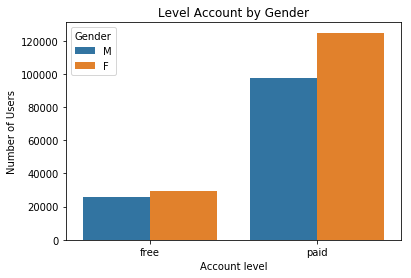

In [73]:
sns.barplot(x='level', y='count',hue='gender', data=df_gender_level);
plt.xlabel('Account level')
plt.ylabel('Number of Users')
plt.title('Level Account by Gender')
plt.legend(title='Gender', loc='best');
plt.savefig('Level_Account_by_Gender.png')

This graphic shows that there are more users with a paid account. 
And most users are women.

#### Question: What about the location of the users? Does this feature affects on the level of service?

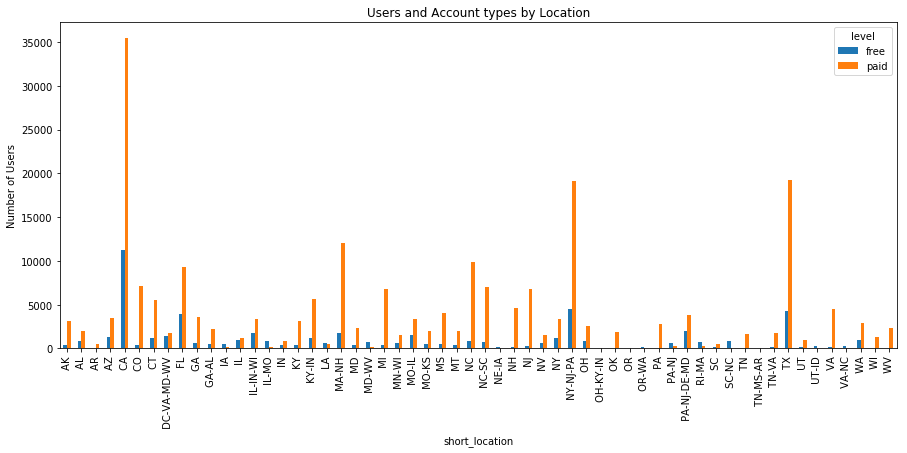

In [74]:
df_location_level = df_valid.select('userId','short_location','level').groupby('short_location','level').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,6))
plt.ylabel('Number of Users')
ax = fig.gca()
df_location_level.pivot(index='short_location', columns='level', values='count').plot(kind='bar', ax=ax)
plt.title('Users and Account types by Location')
plt.savefig('df_location_level.png')

The previous graphic shows there are more users (also with paid accounts) in California (CA), New York (NY) and Texas (TX)

#### Question: What about the UserAgent? Is there a difference between subscriptors?

In [75]:
# Now let's see the different browsers the users login, that indicates different Operating Systems from users
nos = df_valid.select('userAgent','userId').distinct().groupby('userAgent').count().show()

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Mac...|    1|
|"Mozilla/5.0 (Win...|    4|
|Mozilla/5.0 (X11;...|    1|
|"Mozilla/5.0 (Mac...|   16|
|"Mozilla/5.0 (Mac...|    2|
|Mozilla/5.0 (Maci...|    2|
|Mozilla/5.0 (Wind...|    1|
|Mozilla/5.0 (Wind...|    4|
|Mozilla/5.0 (comp...|    3|
|"Mozilla/5.0 (Win...|    7|
|Mozilla/5.0 (Maci...|    9|
|"Mozilla/5.0 (Win...|    1|
|"Mozilla/5.0 (iPh...|    1|
|"Mozilla/5.0 (Win...|   10|
|Mozilla/5.0 (Wind...|   18|
|Mozilla/5.0 (comp...|    1|
|Mozilla/5.0 (comp...|    1|
|"Mozilla/5.0 (Mac...|    1|
|"Mozilla/5.0 (Mac...|    1|
|"Mozilla/5.0 (Win...|    3|
+--------------------+-----+
only showing top 20 rows



In [76]:
df_os_level = df_valid.select('userId','userAgent','level').groupby('userAgent','level').count().toPandas().sort_values(by='count')
df_os_level.head()

,userAgent,level,count
75,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",free,5
87,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,free,25
65,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; r...,free,35
94,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,paid,37
100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,free,62


In [78]:
# Maybe it's interesting augment our dataset with the device the users utilize our Sparkify service
# let's map the operating system, through the Browser

map = {'macintosh':'MAC', 'iphone':'IPHONE','ipad':'IPAD',
           'x11':'LINUX','compatible':'WINDOWS',
           'windows nt 5.0':'WINDOWS','windows nt 5.1':'WINDOWS',
          'windows nt 6.1':'WINDOWS', 'windows nt 6.0':'WINDOWS',
          'windows nt 6.2':'WINDOWS'}

classify_os = udf(lambda x: map[re.findall('\(([^\)]*)\)', x)[0].split(';')[0].lower()])

df_valid = df_valid.withColumn('OS', classify_os(df_valid.userAgent))
#df_valid.select('OS').distinct().show(5)

In [79]:
#df_os_level = df_valid.select('userId','OS','level').groupby('OS','level').count().toPandas().sort_values(by='count')
#fig = plt.figure(figsize=(15,6))
#plt.ylabel('Number of Users')
#ax = fig.gca()
#df_os_level.pivot(index='OS', columns='level', values='count').plot(kind='bar', ax=ax)
#plt.savefig('df_os_level.png')

In [80]:
songs_in_hour = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float"))

In [81]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [82]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

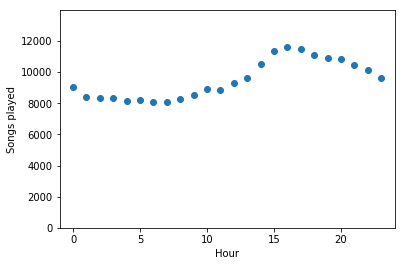

In [83]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

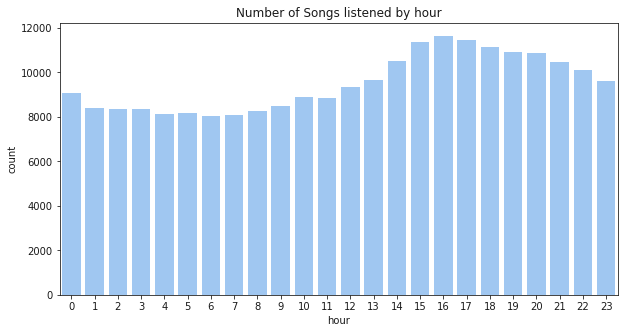

In [84]:
sns.set_color_codes("pastel")
plt.figure(figsize=(10,5))
sns.barplot(x='hour', y='count', data=songs_in_hour_pd, color="b")
plt.title('Number of Songs listened by hour')
plt.ylabel('count');
plt.savefig('df_number_songs_by_hour.png')

In [85]:
# Now let's see if there are days when people listen more songs
songs_in_days = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.day_of_month).count().orderBy(df_valid.day_of_month.cast("float"))

In [86]:
songs_in_days_pd = songs_in_days.toPandas()
songs_in_days_pd.day_of_month = pd.to_numeric(songs_in_days_pd.day_of_month)

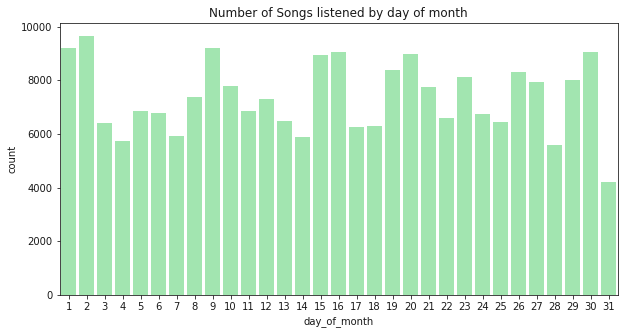

In [87]:
sns.set_color_codes("pastel")
plt.figure(figsize=(10,5))
sns.barplot(x='day_of_month', y='count', data=songs_in_days_pd, color="g")
plt.title('Number of Songs listened by day of month')
plt.ylabel('count');
plt.savefig('df_number_songs_by_day_of_month.png')

# Users Downgrade Their Accounts

To find when users downgrade their accounts, let's use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events and then flag those log entries

### Now let's calculate the users who downgrade the service, that is, the users that downgraded or cancellate the service

In [88]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [89]:
df_valid.select(["userId", "firstname", "ts", "page", "level"]).where((df_valid.page == "Downgrade") | (df_valid.page == "Cancellation Confirmation") | (df_valid.page == "Submit Downgrade") ).sort("ts").show(5)

+------+---------+-------------+----------------+-----+
|userId|firstname|           ts|            page|level|
+------+---------+-------------+----------------+-----+
|    54|    Alexi|1538354749000|       Downgrade| paid|
|    95|    Faigy|1538373286000|       Downgrade| paid|
|    95|    Faigy|1538392612000|       Downgrade| paid|
|   131|     Kael|1538393618000|       Downgrade| paid|
|   131|     Kael|1538393619000|Submit Downgrade| paid|
+------+---------+-------------+----------------+-----+
only showing top 5 rows



In [90]:
df_valid = df_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [91]:
df_valid.select('downgraded').show(5)

+----------+
|downgraded|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [92]:
df_downgrade = df_valid.select('userId','gender','downgraded').distinct().groupby('gender','downgraded').count().toPandas().sort_values(by='count')
df_downgrade.head()

,gender,downgraded,count
0,M,1,21
2,F,1,28
1,F,0,104
3,M,0,121


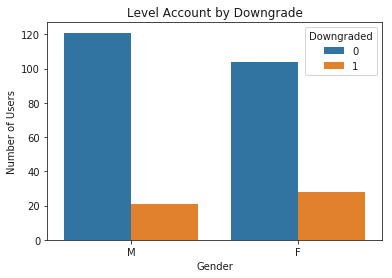

In [93]:
sns.barplot(x='gender', y='count',hue='downgraded', data=df_downgrade);
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Gender by Downgrade')
plt.legend(title='Downgraded', loc='best');
plt.savefig('Gender_by_Downgrade.png')

#### Women are slightly more likely to downgrade than men

In [118]:
df_downgrade_level = df_valid.select('userId','level','downgraded').distinct().groupby('level','downgraded').count().toPandas().sort_values(by='count')
df_downgrade_level.head()

,level,downgraded,count
2,paid,1,49
0,paid,0,165
1,free,0,195


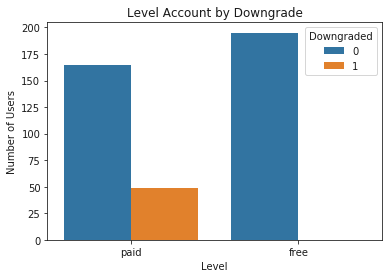

In [119]:
sns.barplot(x='level', y='count',hue='downgraded', data=df_downgrade_level);
plt.xlabel('Level')
plt.ylabel('Number of Users')
plt.title('Level Account by Downgrade')
plt.legend(title='Downgraded', loc='best');
plt.savefig('Level_by_Downgrade.png')

# Now let's calculate the users who churn, that is, the users that confirmed cancellation

In [95]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_valid = df_valid.withColumn("churn", flag_churn_event(df_valid.page))

In [96]:
df_valid.select('churn').show(5)

+-----+
|churn|
+-----+
|    0|
|    0|
|    0|
|    0|
|    0|
+-----+
only showing top 5 rows



In [136]:
# Let's count the number of user cancellations (churns) --> there are 52 users who have cancel the service
df_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(df_valid.churn == 1).sort("ts").count()

52

In [131]:
# Let's drop the UserId duplicates and then count the users who churned
# And prepare the data to be plotted with a sns, so we need to convert to a Pandas Dataframe
total_churn = df_valid.dropDuplicates(['userId','churn']).groupby(['churn']).count().toPandas()

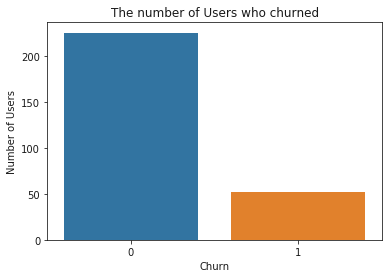

In [132]:
sns.barplot(x='churn', y='count', data=total_churn);
plt.xlabel('Churn')
plt.ylabel('Number of Users')
plt.title('The number of Users who churned')
plt.legend(title='Churn', loc='best');
plt.savefig('Users_who_churned.png')

In [97]:
df_valid.select('userId','gender','churn').distinct().groupby('gender','churn').count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|  104|
|     F|    1|   20|
|     M|    0|  121|
+------+-----+-----+



In [98]:
df_churn_gender = df_valid.select('userId','gender','churn').groupby('gender','churn').count().toPandas().sort_values(by='count')

In [99]:
df_churn_gender 

,gender,churn,count
2,F,1,20
0,M,1,32
3,M,0,123544
1,F,0,154558


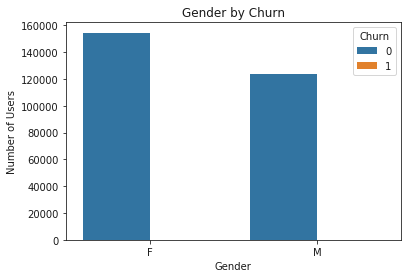

In [124]:
sns.barplot(x='gender', y='count',hue='churn', data=df_churn_gender);
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Gender by Churn')
plt.legend(title='Churn', loc='best');
plt.savefig('Gender by Churn.png')

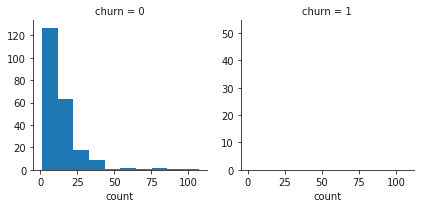

In [133]:
sessionId_total_churn = df_valid.dropDuplicates(['userId','churn', 'sessionId']).groupby(['userId','churn']).count().toPandas()
#churn_df = df_valid.select('userId', 'churn', 'sessionId').distinct().groupBy(['userId', 'churn']).count().toPandas()

# compare two groups of users
g = sns.FacetGrid(sessionId_total_churn, col="churn", sharey=False)
g.map(plt.hist, "count");

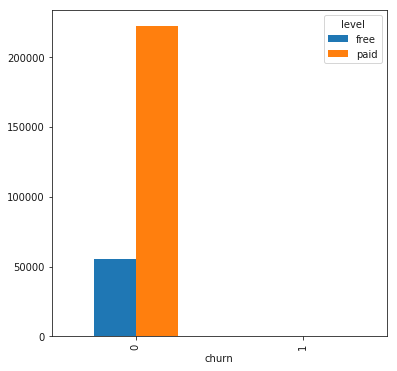

In [128]:
df_count_ = df_valid.select('userId','level','churn').groupby('level','churn').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
#plt.rcParams["font.size"] = "12"
df_count_.pivot(index='churn', columns='level', values='count').plot(kind='bar', ax=ax)
# plt.savefig('df_churnl_level.png')

In [106]:
from pyspark.sql import Window

In [107]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [108]:
df_valid = df_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [141]:
df_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(df_valid.userId == "131").sort("ts").collect()[0]

Row(userId='131', firstname='Kael', ts=1538384355000, page='NextSong', level='free', phase=2)

In [137]:
# Let's see more information about the 52 users who churned
df_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(df_valid.churn == 1).sort("ts").collect()[0]

Row(userId='100011', firstname='Sebastian', ts=1538417085000, page='Cancellation Confirmation', level='free', phase=0)

In [138]:
avg_time_user = df_valid.agg({"itemInSession": "max"}).collect()[0]

In [139]:
avg_time_user

Row(max(itemInSession)=1321)

In [142]:
#### Question: Is there a difference in time between the users who churned and who did not churn? 

In [140]:
member_time = df_valid.select('userId','registration','ts','churn')

In [ ]:
member_time

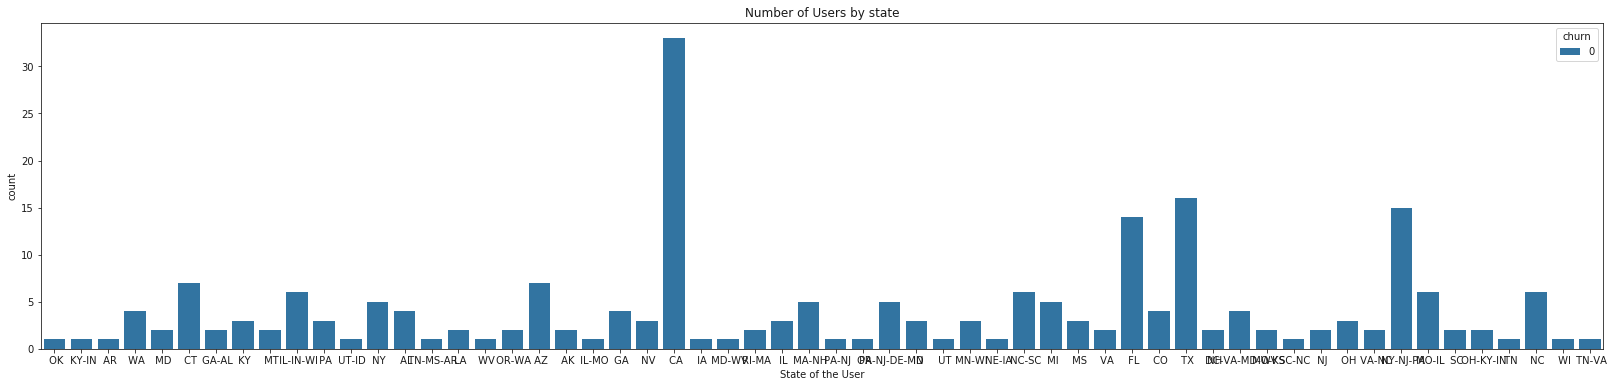

In [149]:
#### Question: Is there a difference in the location between the users who churned and who did not churn? 
state_df = df_valid.dropDuplicates(['userId', 'short_location']).groupby(['short_location', 'churn']).count().toPandas()

fig = plt.figure(figsize=(28,6))
ax = sns.barplot(x='short_location', y='count', hue='churn', data=state_df);
plt.xlabel('State of the User')
plt.ylabel('count')
plt.title('Number of Users by state');
plt.legend(title='churn', loc='best');


In [116]:
df_valid['song'].mean()

TypeError: 'Column' object is not callable

In [ ]:
print("The average person listens {:.4f} songs, 99% of people have {} level, and the most played song ever is {}.".format(df_valid['song'].mean(),df_valid['level'].quantile(0.99), df_valid['song'].max()))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# Let's remember the fields of our datset
# There are some fields that we can transform from categorical to numerical: e.g: gender, level
df_valid.printSchema()

In [ ]:
# Let's change gender into a numerical,binary field (0/1)
gender = df_valid.select(['userId', 'gender']).dropDuplicates(['userId']).replace(['F', 'M'], ['0', '1'], 'gender')
df_gender = gender.withColumn('gender', gender.gender.cast('int'))
df_gender.show(3)

In [ ]:
# Let's change level into a numerical,binary field (0/1)
level = df_valid.select(['userId', 'level']).dropDuplicates(['userId']).replace(['free', 'paid'], ['0', '1'], 'level')
df_level = level.withColumn('level', level.level.cast('int'))
df_level.show(3)

In [ ]:
# Let's change churn into a numerical,binary field (0/1)
churn = df_valid.select(['userId','churn']).dropDuplicates(['userId'])
df_churn = churn.withColumn('churn', churn.churn.cast('int'))
df_churn.show(5) 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.